In [1]:
import sys

sys.path.append("../..")
sys.path.append("../../../py-modelrunner")
sys.path.append("../../../py-pde")

import time
from collections import Counter
from itertools import product

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd

from tqdm.auto import tqdm

In [2]:
from multicomp import *

In [3]:
sys.path.append("../../simulations")

In [17]:
from chi

array([[0.        , 3.0810865 , 3.31960188, 2.70378853, 2.72412304],
       [3.0810865 , 0.        , 2.55546497, 3.48528165, 2.69085095],
       [3.31960188, 2.55546497, 0.        , 3.42773501, 2.08631197],
       [2.70378853, 3.48528165, 3.42773501, 0.        , 3.48297792],
       [2.72412304, 2.69085095, 2.08631197, 3.48297792, 0.        ]])

In [18]:
m = MultiphaseSystem.from_random_composition(f, 5)
# m = MultiphaseSystem.from_demixed_composition(f, c_dense=0.75)
m.phis

array([[0.19244934, 0.17493019, 0.20563643, 0.00538086, 0.19375049],
       [0.06201897, 0.16274288, 0.1585431 , 0.18258859, 0.25078409],
       [0.34878487, 0.04428405, 0.15902042, 0.00202015, 0.25211659],
       [0.16747311, 0.02650531, 0.31898018, 0.17722058, 0.00465793],
       [0.08586723, 0.06727793, 0.079961  , 0.25698134, 0.33483313]])

In [19]:
phi = m.phis[0]
f.pressure(phi)

2.0954814194064983

In [20]:
phi_sol = 1 - phi.sum()
1 / 2 * f.chis @ phi @ phi - np.log(phi_sol)

2.0954814194064983

In [21]:
[np.linalg.eigvals(f.hessian(c)) for c in m.phis]

[array([191.69693742,  29.57745246,   1.63106508,   3.1084047 ,
          2.71111334]),
 array([47.23772349, 10.60343486,  1.10922448,  3.78253274,  2.58192243]),
 array([5.00788350e+02, 3.97594879e+01, 1.27938840e+01, 2.18712806e-01,
        2.95789447e+00]),
 array([218.76547828,  45.31553214,  15.98663494,   3.1058937 ,
          0.37591233]),
 array([50.06230222, 11.37801506,  8.69201919,  4.4371759 , -0.11744245])]

In [23]:
[f.is_stable(c) for c in m.phis]

[True, True, True, True, False]

In [24]:
class RelaxationDynamics2(RelaxationDynamics):
    def evolve_scipy(self, t_range, interval=0.1):
        """try to use the scipy solver to evolve system"""
        shape = (self.num_phases, self.num_comps)
        rhs = self._make_evolution_rate()

        def rhs_scipy(t, y):
            return rhs(y.reshape(shape)).flat

        t_eval = np.arange(0, t_range, interval)
        res = integrate.solve_ivp(
            rhs_scipy, (0, t_range), self.mixture.phis.flat, first_step=1e-4
        )  # , t_eval=t_eval)
        return res.t, res.y.reshape((len(res.t),) + shape)

    def evolve_adaptive(self, t_range, dt=1e-5):
        res = []
        times = []
        cs = self.mixture.phis.copy()
        rhs = self._make_evolution_rate()

        t_max = 100
        t_tracker = 1

        progress = tqdm(total=t_max)

        dt = 1e-4
        t = 0
        steps = 0
        t_out = 0
        while t < t_max:
            # store result
            if t >= t_out:
                times.append(t)
                res.append(cs.copy())
                progress.update(t_tracker)
                t_out += t_tracker

            # make a step
            dc = rhs(cs)
            while True:
                cs_new = cs + dt * dc
                valid = (
                    np.all(np.isfinite(cs_new))
                    and np.all(cs_new > 0)
                    and np.all(cs_new.sum(axis=-1) < 1)
                )
                if valid:
                    break
                else:
                    dt /= 1.2
                    if dt < 1e-8:
                        break
            if dt < 1e-8:
                print("Time step too small")
                break
            cs += 0.5 * dt * dc
            t += 0.5 * dt
            steps += 1
            dt *= 1.1
        #     if steps % 10000 == 0:
        #         print(t, dt)

In [9]:
r = RelaxationDynamics2(m)

In [10]:
rhs = r._make_evolution_rate()
np.allclose(r.evolution_rate(), rhs(m.phis))

True

In [11]:
# r.evolve_adaptive(1e3)

In [12]:
result = r.evolve(1e3, dt=1, interval=1.0, tolerance=1e-5, save_intermediate_data=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
r.diagnostics

{'num_steps': 1232, 'steps_tracker': 1000, 'dt_last': 0.0625}

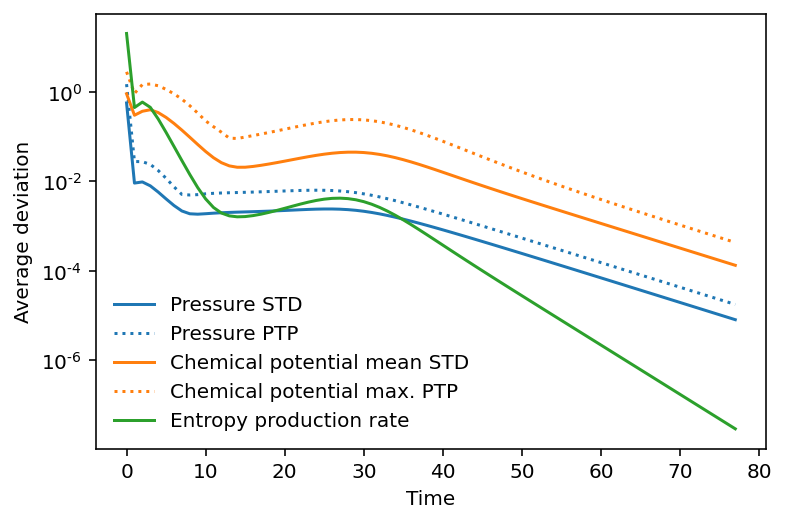

In [14]:
plot_convergence(*result)

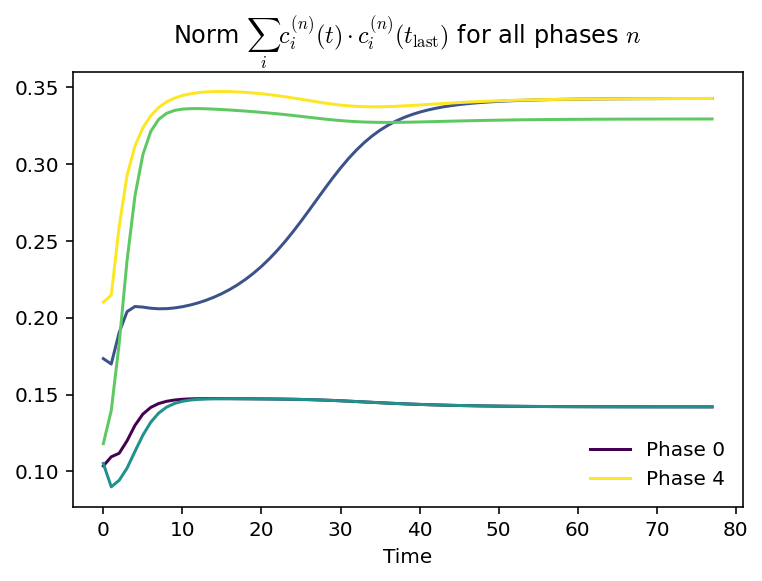

In [15]:
plot_concentrations(*result)

(array([11.,  5.,  0.,  4.,  2.,  0.,  0.,  0.,  0.,  3.]),
 array([5.05740818e-04, 5.72598555e-02, 1.14013970e-01, 1.70768085e-01,
        2.27522200e-01, 2.84276314e-01, 3.41030429e-01, 3.97784544e-01,
        4.54538659e-01, 5.11292773e-01, 5.68046888e-01]),
 <BarContainer object of 10 artists>)

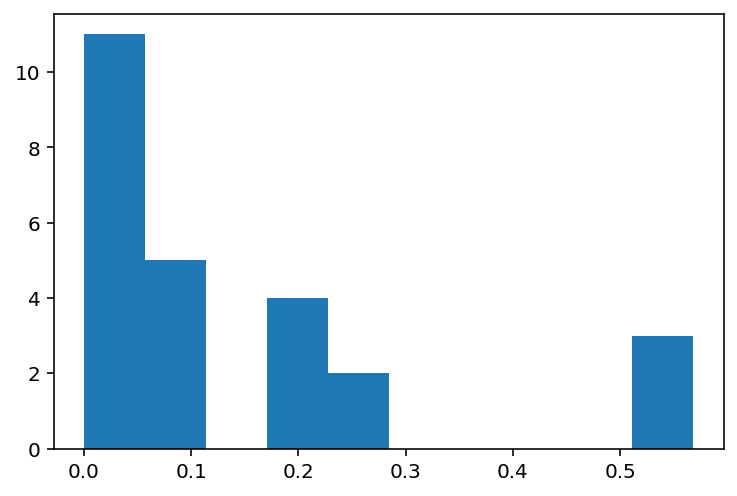

In [16]:
plt.hist(result[1][-1].phis.flat)